<a href="https://colab.research.google.com/github/TALeonard/19ma573thomasleonard/blob/master/src/hw4_bsm_calibration_v01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First, we need to import information from GitHub, as well as any modules we intend to use.

In [1]:
#!git clone https://github.com/TALeonard/19ma573thomasleonard.git #Only run once!

Cloning into '19ma573thomasleonard'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 111 (delta 34), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (111/111), 332.63 KiB | 10.39 MiB/s, done.
Resolving deltas: 100% (34/34), done.


In [2]:
cd /content/19ma573thomasleonard/src/

/content/19ma573thomasleonard/src


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as so
from european_options_class import VanillaOption
from gbm_1d_class_v02 import Gbm

Now, import the data. I am using the optiondata1.txt file found in my /src directory. This data is based on options on AAPL as observed Monday, February 4. I realize the assignment likely mentioned "Today" in the context of the day the assignment went live, but this is what I have. That and the values don't end up really mattering in that sense of "we need this data at this time" since I believe this is more meant as a "demonstrate we can do what the assignment wants, i.e. working with implied volatility and calibration."

In [4]:

'''======
Read data
========='''
#Read four-column data
#columns are otype, maturity, strike, option_price
np_option_data1 = np.loadtxt('optiondata1.txt', comments='#', delimiter=',')

print('>>>>>>otype, maturity, strike, option_price')
print(np_option_data1)

>>>>>>otype, maturity, strike, option_price
[[  1.           0.37260274 155.          20.49      ]
 [  1.           0.37260274 160.          17.05      ]
 [  1.           0.37260274 165.          13.84      ]
 [  1.           0.37260274 170.          11.        ]
 [  1.           0.37260274 175.           8.6       ]
 [  1.           0.37260274 180.           6.5       ]
 [  1.           0.37260274 185.           4.8       ]
 [  1.           0.37260274 190.           3.48      ]]


The price of AAPL as of when this was taken (after end-of-day Monday, February 4) was $172.86 (the listed opening price on Yahoo Finance for Tuesday, February 5). The LIBOR rate for February 4, 2019 is 2.73438%. Supply these as our initial state.

In [0]:
'''==============
below are from the market data for underlying process
================='''
gbm1 = Gbm(
    init_state = 172.86, #market data
    drift_ratio = .0273438, #market data
    vol_ratio = .1 #initial guess
)

In [0]:
'''====================
create option_list from the data
======================='''

num_row = np_option_data1.shape[0]
option_list = []

for i in range(num_row):
  option1 = VanillaOption(
      otype = np_option_data1[i,0],
      strike = np_option_data1[i,2],
      maturity = np_option_data1[i,1],
      market_price = np_option_data1[i,3]
  )
      
  option_list.append(option1)

In [0]:
#expand one column for vol
np_option_data2 = np.append(np_option_data1, np.zeros([num_row,1]), axis = 1)

In [0]:
'''================
define an error function
===================='''
def error_function(vol, gbm, option):
  gbm.vol_ratio = vol
  return np.abs(option.market_price - gbm.bsm_price(option))

'''==========
define a method to seek for an implied volatility
============'''

def implied_volatility(gbm, option):
  init_vol = .1 #initial guess
  return so.fmin(error_function, init_vol, args = (gbm, option), disp = 0)[0]

In [9]:
#compute implied vols and add them into the last column
for i in range(num_row):
  np_option_data2[i,4] = implied_volatility(gbm1, option_list[i])
  
print('>>>>>>otype, maturity, strike, option_price, implied vol')
print(np_option_data2)

>>>>>>otype, maturity, strike, option_price, implied vol
[[1.00000000e+00 3.72602740e-01 1.55000000e+02 2.04900000e+01
  1.70390625e-01]
 [1.00000000e+00 3.72602740e-01 1.60000000e+02 1.70500000e+01
  1.92402344e-01]
 [1.00000000e+00 3.72602740e-01 1.65000000e+02 1.38400000e+01
  2.00703125e-01]
 [1.00000000e+00 3.72602740e-01 1.70000000e+02 1.10000000e+01
  2.05087891e-01]
 [1.00000000e+00 3.72602740e-01 1.75000000e+02 8.60000000e+00
  2.08544922e-01]
 [1.00000000e+00 3.72602740e-01 1.80000000e+02 6.50000000e+00
  2.08515625e-01]
 [1.00000000e+00 3.72602740e-01 1.85000000e+02 4.80000000e+00
  2.08261719e-01]
 [1.00000000e+00 3.72602740e-01 1.90000000e+02 3.48000000e+00
  2.08320313e-01]]


For visibility, print the last column only. Jus so we can see what sort of range we're looking at in a way that isn't marred by scientific notation and clumped in with other numbers we already knew.

In [10]:
print(np_option_data2[:,4])

[0.17039063 0.19240234 0.20070313 0.20508789 0.20854492 0.20851563
 0.20826172 0.20832031]


Now, produce a graph of the volatility smile. Or what we hope will be a smile.

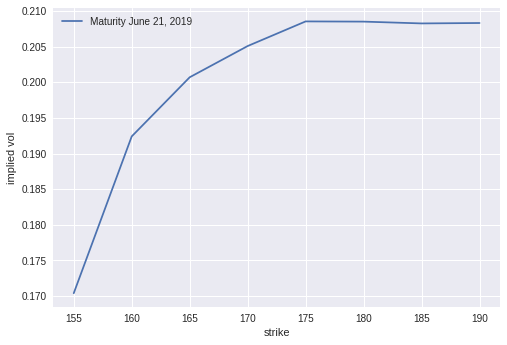

In [11]:
plt.plot(np_option_data2[:,2], np_option_data2[:,4], label = 'Maturity June 21, 2019')
plt.ylabel('implied vol')
plt.xlabel('strike')
plt.legend();

We don't see a smile, it turns out. In fact, we see a frown if anything. 

Interesting results aside, now we shall calibrate the BSM volatility for the option prices, $\hat \sigma$. First, we define a "new" error function which will be better suited to this than the first was.

In [0]:
'''==========
define a method for error function
============'''

def error_function(vol, gbm, option_list):
  gbm.vol_ratio = vol
  err1 = 0
  for i in np.arange(len(option_list)):
    err1 = err1 + ((option_list[i]).market_price - gbm.bsm_price(option_list[i]))**2    
  return err1

In [0]:
'''==========
define a method to seek for a calibrated volatility
============'''

def bsm_calibration(gbm, option_list):
  init_vol = .1 #initial guess
  return so.fmin(error_function, init_vol, args = (gbm, option_list), disp = 0)[0]

In [14]:
calibrated_volatility1 = bsm_calibration(gbm1, option_list)
print('>>>>>>>> calibrated_volatility is ' + str(calibrated_volatility1))
gbm1.vol_ratio = calibrated_volatility1

>>>>>>>> calibrated_volatility is 0.20351562500000037


In [15]:
#find calibrated option price
optiondata1_calibrated_price = [gbm1.bsm_price(option_list[i]) for i in range(len(option_list))]
print('>>>>>>>>> this is option price calculated from calibrated vol')
optiondata1_calibrated_price

>>>>>>>>> this is option price calculated from calibrated vol


[21.247299778928905,
 17.394126421827792,
 13.943402551454753,
 10.936149097744021,
 8.388690817984582,
 6.292073198517244,
 4.61544039323266,
 3.31205376939824]

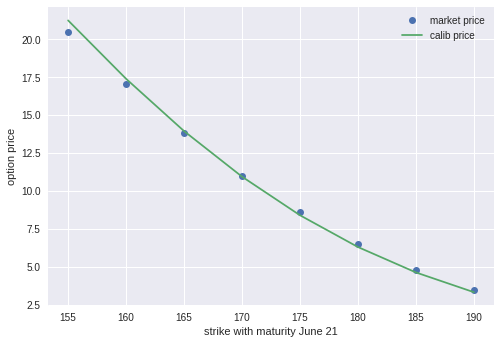

In [16]:
x_co = [option_list[i].strike for i in range(len(option_list))]
y_co = [option_list[i].market_price for i in range(len(option_list))]
plt.plot(x_co, y_co, 'o', label='market price')

y_co = optiondata1_calibrated_price
plt.plot(x_co, y_co, label = 'calib price')

plt.ylabel('option price')
plt.xlabel('strike with maturity June 21')
plt.legend();

The calibration appears to be working quite well. It's not perfect, but the values are quite accurate and I am satisfied with this result. Compare differences.

In [0]:
#create list of differences between real price and calibrated price.
pricedelta = [option_list[i].market_price - optiondata1_calibrated_price[i] for i in range(len(option_list))]

In [0]:
deltalist = [] #empty vector to store the price deltas in, for display purposes.
for i in range(num_row):
  delta = [np_option_data1[i,2], pricedelta[i]]
  deltalist.append(delta)

In [19]:
displaytable = np.array(deltalist)
print(displaytable)

[[ 1.55000000e+02 -7.57299779e-01]
 [ 1.60000000e+02 -3.44126422e-01]
 [ 1.65000000e+02 -1.03402551e-01]
 [ 1.70000000e+02  6.38509023e-02]
 [ 1.75000000e+02  2.11309182e-01]
 [ 1.80000000e+02  2.07926801e-01]
 [ 1.85000000e+02  1.84559607e-01]
 [ 1.90000000e+02  1.67946231e-01]]
